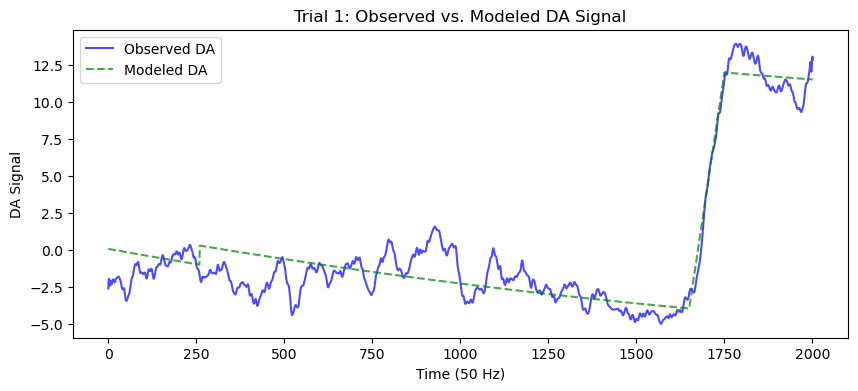

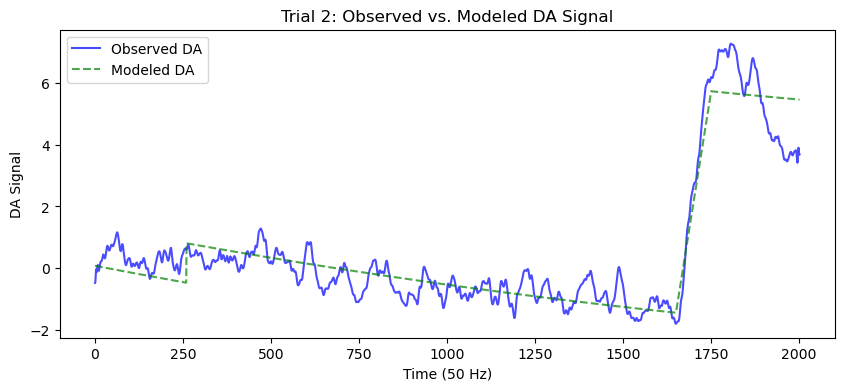

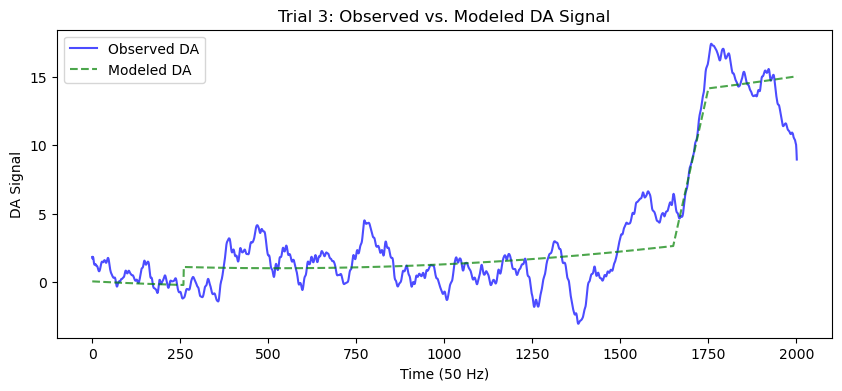

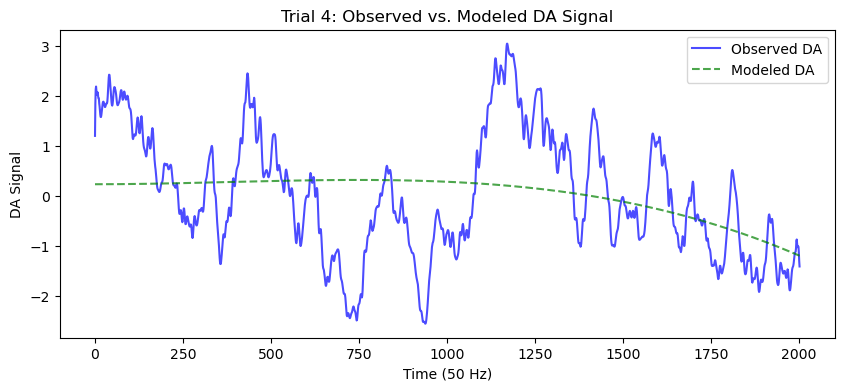

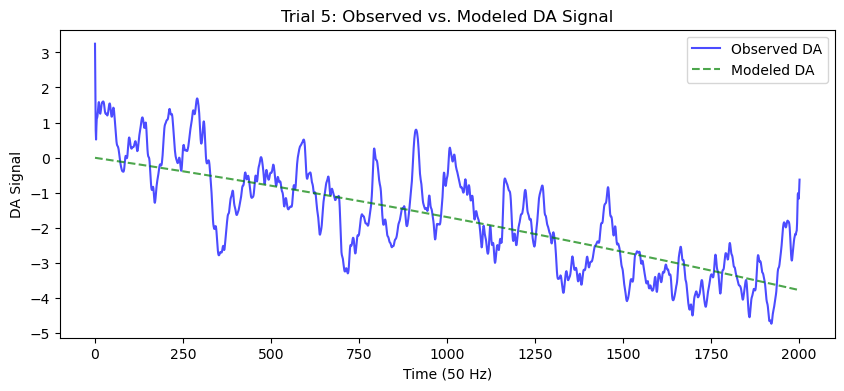

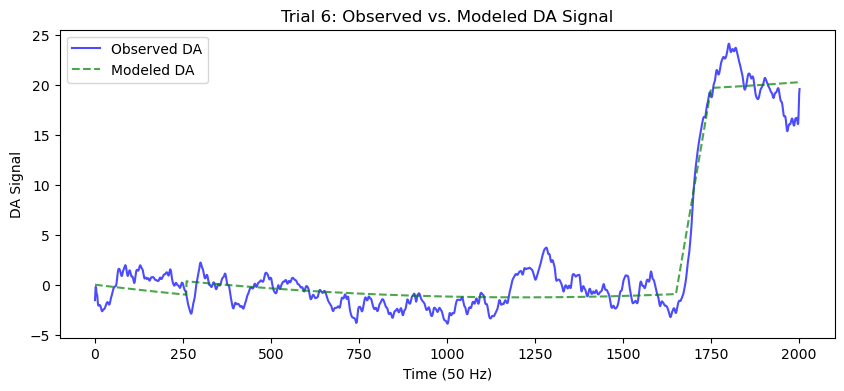

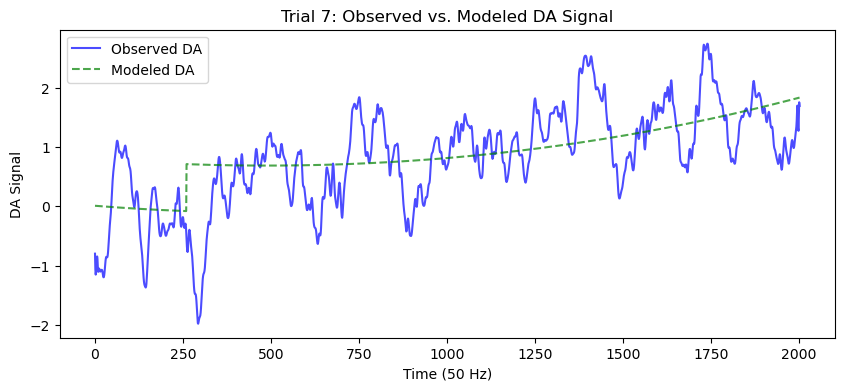

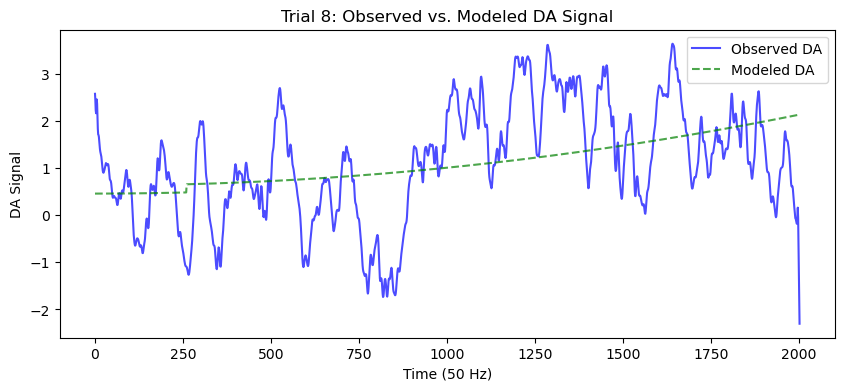

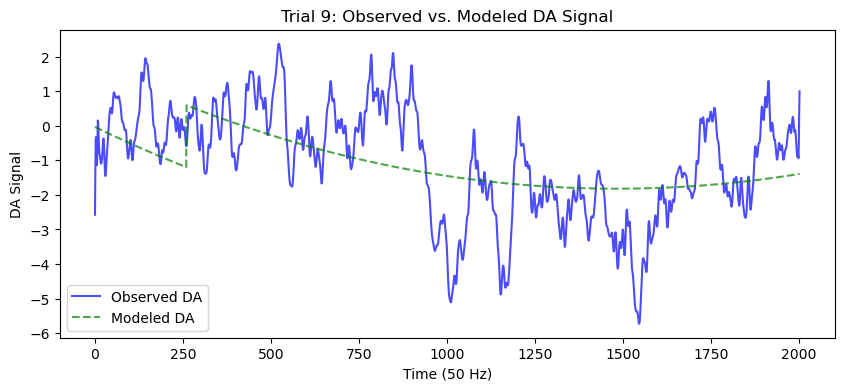

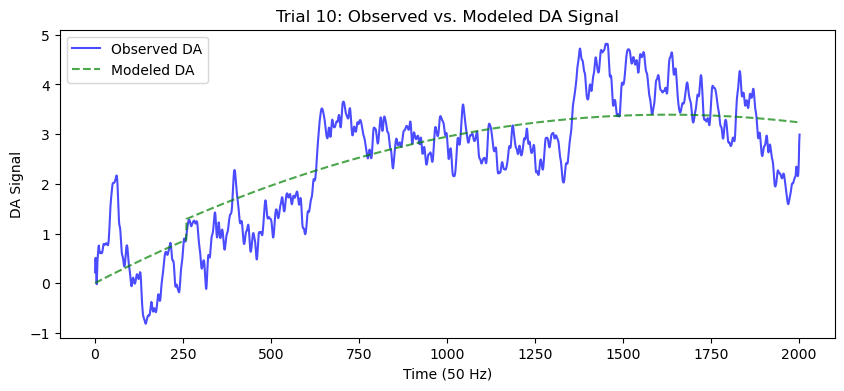

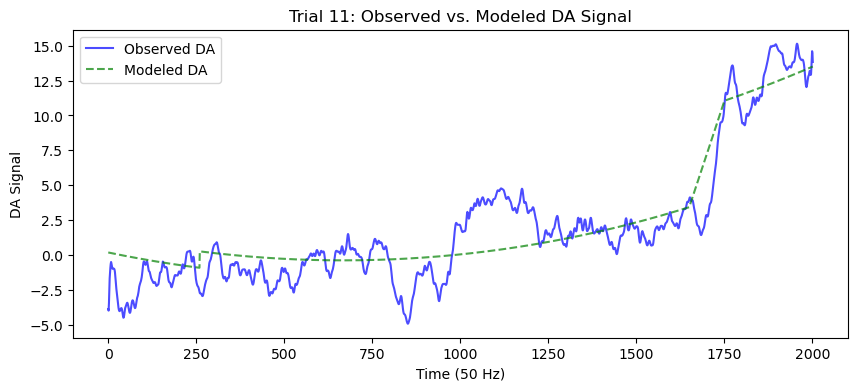

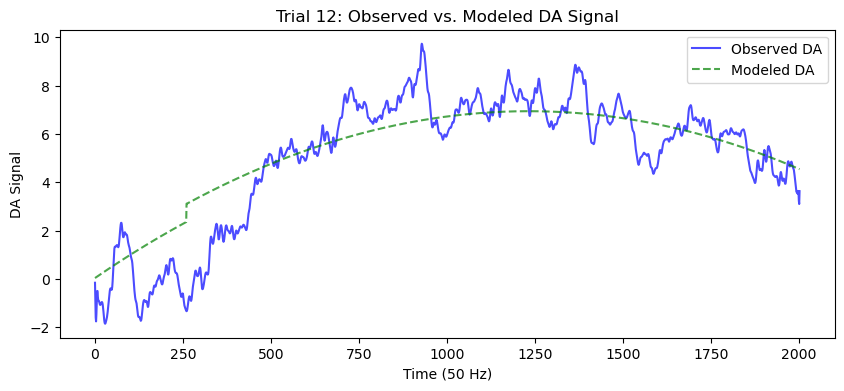

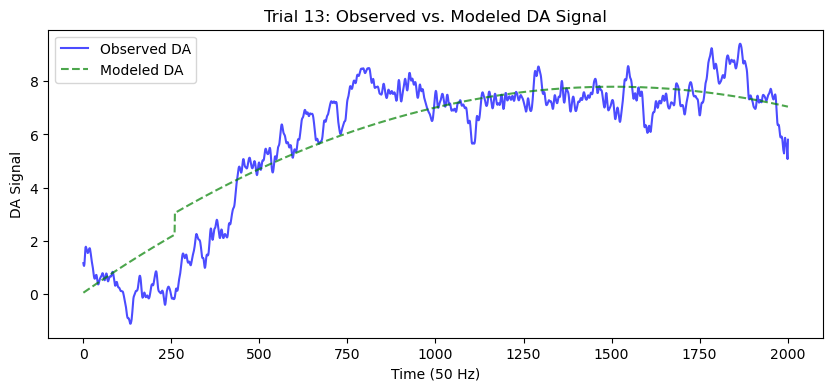

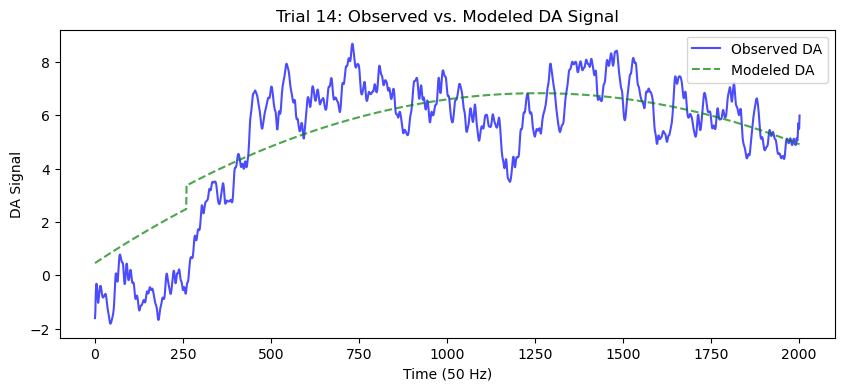

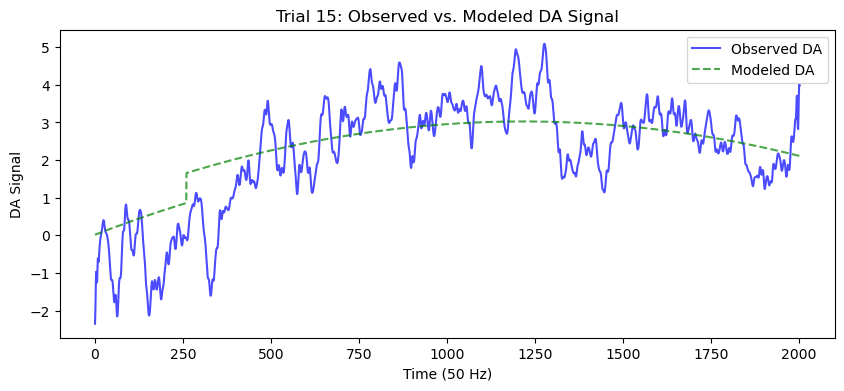

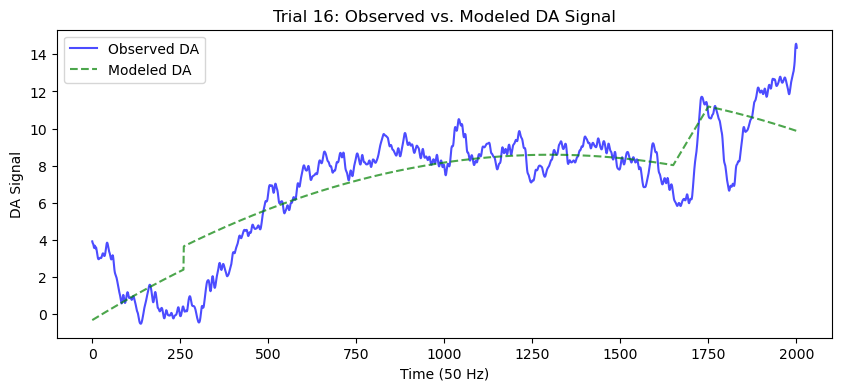

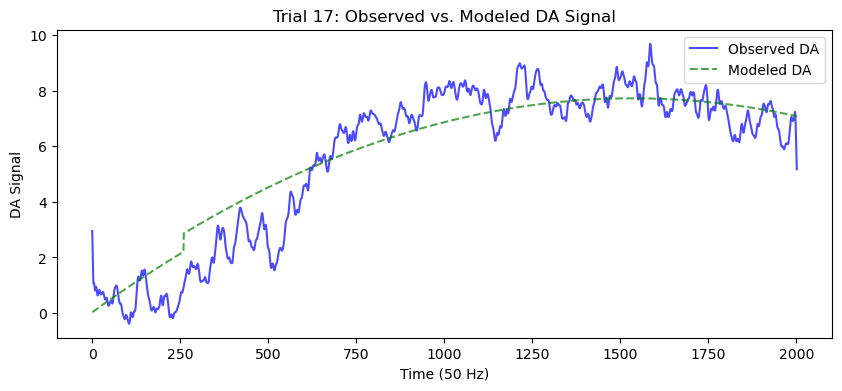

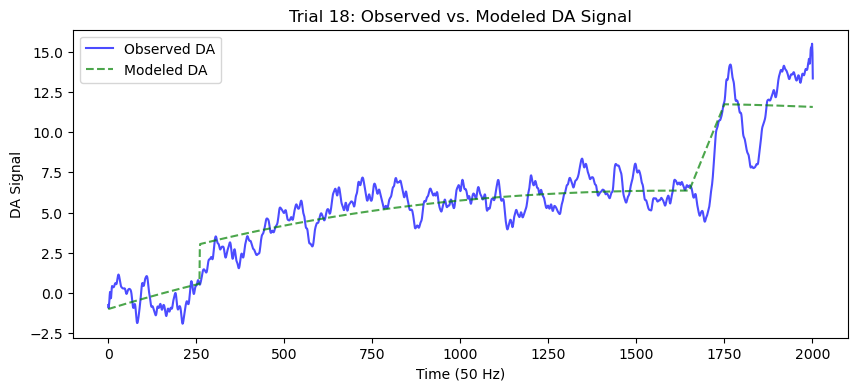

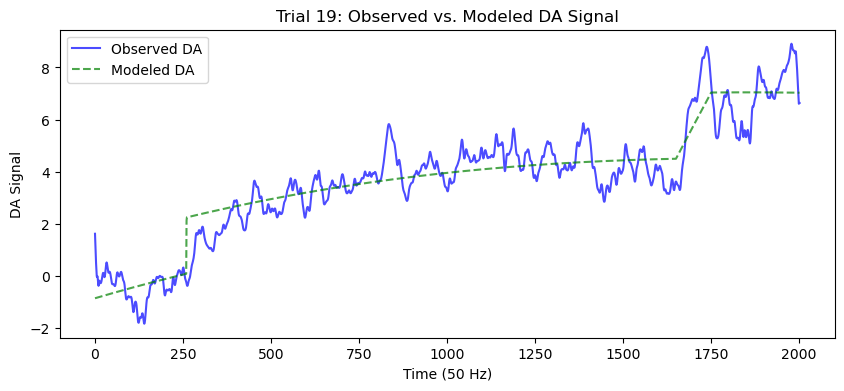

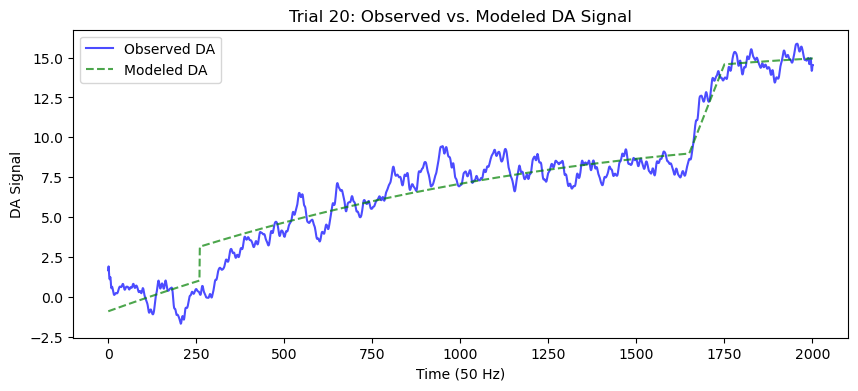

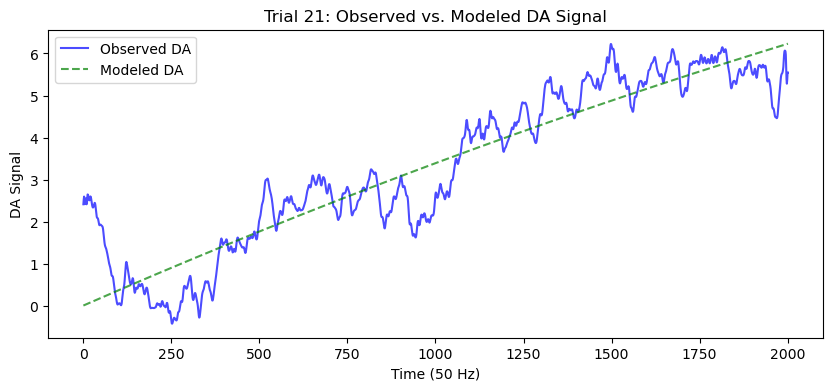

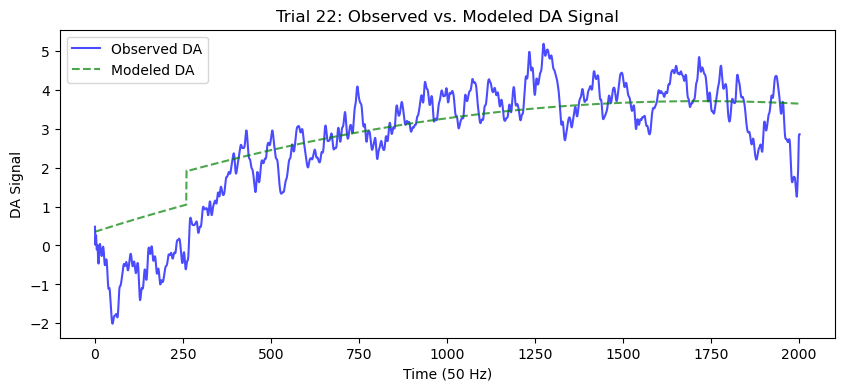

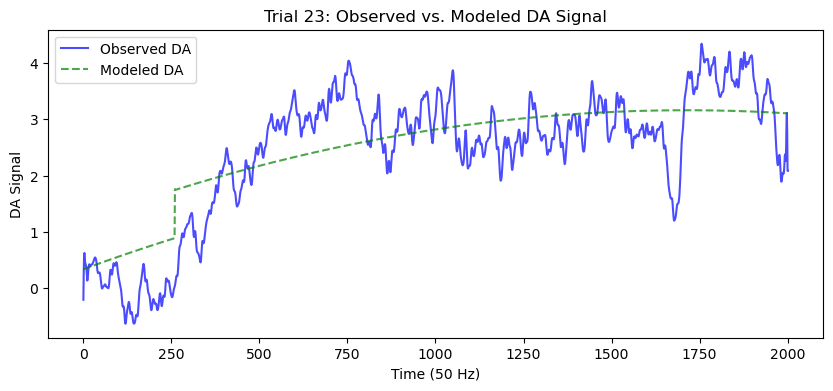

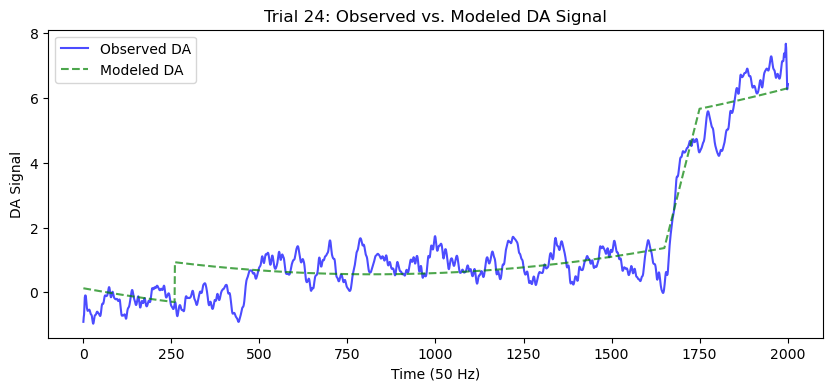

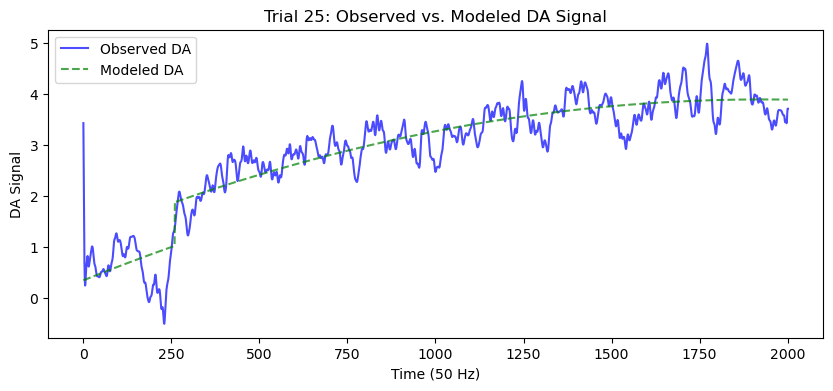

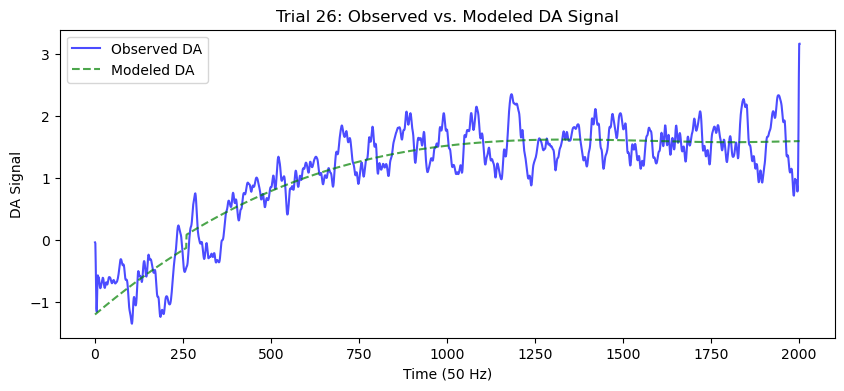

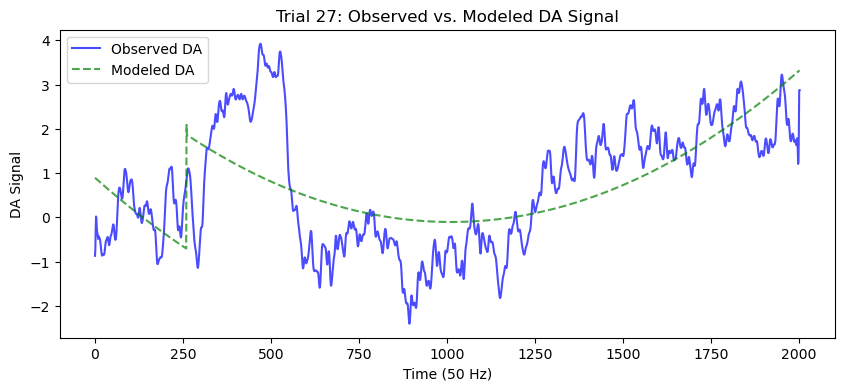

Overall MSE across all trials: 1.2436972771200232
Optimized Parameters for Each Trial:
    Base Alpha     Gamma  Uncertainty (a)  Baseline (b)  Beta (Dynamic α)  \
0     0.183891  0.500000        -0.000021      0.072028         -0.387548   
1     0.083010  0.500000        -0.000022      0.080127         -0.372231   
2     0.130116  0.500000        -0.000067      0.035234         -0.420354   
3     0.859638  0.490527        -0.999804      0.234237         -1.028638   
4     0.997756  0.496626        -0.000002     -0.007231          5.000000   
5     0.244979  0.500000        -0.000052      0.062591         -0.446203   
6     0.397293  0.498397        -0.000019      0.009000         -0.812647   
7     0.010000  0.495578        -0.246908      0.457045          0.208103   
8     0.830085  0.456705         0.000024     -0.036105         -0.748452   
9     0.703781  0.385366        -0.000003      0.005542          0.330423   
10    0.065692  0.499068        -0.000284      0.189289         -0

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load Data
global fiber_data 
fiber_data = pd.read_csv("./data/yoked/DP116_allTrial_signal.csv", header=None)
corrected_shock_outcomes = pd.read_csv("./data/yoked/dp116_shock_outcome.csv", header=None).values.flatten()
num_trials = fiber_data.shape[0]
num_time_steps = fiber_data.shape[1]
shock_start, shock_end, tone_onset = 1650, 1750, 260

# Define the TD model with Dynamic Parameter Modulation
def td_model_salience_with_dynamic_parameters(trial_data, s_t_vector, params, trial_outcome, trial_history):
    base_alpha, gamma, a, b, beta, lambda_tone, lambda_shock, lambda_omission, lambda_tone_onset = params
    num_time_steps = len(trial_data)

    # Initialize arrays
    da_signal_trial = np.zeros(num_time_steps)
    value_function_trial = np.zeros(num_time_steps)
    td_error_trial = np.zeros(num_time_steps)

    # Initialize the first DA signal with the baseline
    da_signal_trial[0] = 

    # Compute TD error and DA signal for each time step
    for t in range(num_time_steps - 1):
        # Compute value function: V(t) = a * t + b
        value_function_trial[t] = a * t + b

        # External stimulus: S(t) from s_t_vector
        s_t = s_t_vector[t]

        # Update salience weights dynamically based on trial context
        dynamic_lambda_tone = lambda_tone + 0.1 * trial_history.get("tone_success", 0)
        dynamic_lambda_shock = lambda_shock + 0.2 * trial_history.get("recent_shock", 0)
        dynamic_lambda_omission = lambda_omission + 0.2 * trial_history.get("recent_omission", 0)

        # Compute salience weight
        salience_weight = (
            dynamic_lambda_tone +
            dynamic_lambda_shock * (trial_outcome == 1) +
            dynamic_lambda_omission * (trial_outcome == 0) +
            (lambda_tone_onset if t == tone_onset else 0)
        )

        # Compute TD error: δ(t) = α_salience(t) * (r_t + γ * V(t+1) - V(t))
        v_next = a * (t + 1) + b if t + 1 < num_time_steps else 0 
        td_error_trial[t] = salience_weight * (s_t + gamma * v_next - value_function_trial[t])

        # Adjust learning rate dynamically based on prediction error
        dynamic_alpha = base_alpha * (1 + beta * np.exp(-abs(td_error_trial[t])))

        # Add a transient step function for tone onset
        if t == tone_onset:
            da_signal_trial[t] += lambda_tone_onset  # Add step increase at tone onset

        # Update DA signal: Signal(t+1) = Signal(t) + α_t * δ(t)
        da_signal_trial[t + 1] = da_signal_trial[t] + dynamic_alpha * td_error_trial[t]

    return da_signal_trial, td_error_trial, value_function_trial

# Define the optimization function
def optimize_td_model_with_dynamic_parameters(trial_index):
    # Extract observed signal for the trial
    observed_signal = fiber_data.values[trial_index, :]

    # Create external stimulus vector (shock/avoid binary)
    s_t_vector = np.zeros(num_time_steps)
    if corrected_shock_outcomes[trial_index] == 1:
        s_t_vector[shock_start:shock_end] = 1  # Shock trials

    # Define trial history
    trial_outcomes = []  # List to store outcomes for each trial
    trial_outcomes.append(corrected_shock_outcomes[trial_index])
    tone_success = sum(trial_outcomes[-5:])  # Count successes in the last 5 trials
    recent_shock = int(trial_outcomes[-1] == 1) if len(trial_outcomes) > 0 else 0
    recent_omission = int(trial_outcomes[-1] == 0) if len(trial_outcomes) > 0 else 0

    trial_history = {
        "tone_success": tone_success,
        "recent_shock": recent_shock,
        "recent_omission": recent_omission
    }

    # Objective function for optimization
    def td_trial_error_salience(params):
        modeled_signal, _, _ = td_model_salience_with_dynamic_parameters(
            observed_signal, s_t_vector, params, corrected_shock_outcomes[trial_index], trial_history
        )
        return np.sum((observed_signal - modeled_signal) ** 2)  # Sum of squared errors
    
    # Initial guesses and bounds for the parameters
    # base_alpha, gamma, a, b, beta, lambda_tone, lambda_shock, lambda_omission, lambda_tone_onset 
    initial_params = [0.1, 0.9, 0.05, 0.5, 0.1, 0.2, 0.8, -0.8, 0.9] 
    bounds = [
        (0.01, 1), (0,0.5), (-1, 1), (-4, 4), (-5, 5), (0, 5), (-2, 2), (-2, 2), (0, 5)
    ]

    # Optimize parameters using gradient descent
    result = minimize(td_trial_error_salience, initial_params, bounds=bounds, method="L-BFGS-B")
    optimized_params = result.x

    # Compute modeled signal using optimized parameters
    modeled_signal, _, _ = td_model_salience_with_dynamic_parameters(
        observed_signal, s_t_vector, optimized_params, corrected_shock_outcomes[trial_index], trial_history
    )

    # Return trial results
    return trial_index, modeled_signal, optimized_params

# Sequential optimization and plotting
results = []
observed_signals = []  # Store all observed signals
modeled_signals = []  # Store all modeled signals

for trial_index in range(num_trials):
    results.append(optimize_td_model_with_dynamic_parameters(trial_index))
    observed_signal = fiber_data.values[trial_index, :]
    modeled_signal = results[-1][1]

    # Append signals for overall MSE calculation
    observed_signals.append(observed_signal)
    modeled_signals.append(modeled_signal)

    # Plot observed vs. modeled DA signal for the trial
    plt.figure(figsize=(10, 4))
    plt.plot(observed_signal, label="Observed DA", color="blue", alpha=0.7)
    plt.plot(modeled_signal, label="Modeled DA", color="green", linestyle="--", alpha=0.7)
    plt.title(f"Trial {trial_index + 1}: Observed vs. Modeled DA Signal")
    plt.xlabel("Time (50 Hz)")
    plt.ylabel("DA Signal")
    plt.legend()
    plt.show()

# Calculate overall MSE across all trials
def calculate_overall_mse(observed_signals, modeled_signals):
    total_mse = 0
    for obs, mod in zip(observed_signals, modeled_signals):
        total_mse += np.mean((obs - mod) ** 2)
    overall_mse = total_mse / len(observed_signals)  # Average MSE across all trials
    return overall_mse

# Compute and display the overall MSE
overall_mse = calculate_overall_mse(observed_signals, modeled_signals)
print(f"Overall MSE across all trials: {overall_mse}")

# Extract parameters into a DataFrame
optimized_parameters_salience_with_dynamic = [res[2] for res in results]
optimized_parameters_salience_with_dynamic_df = pd.DataFrame(
    optimized_parameters_salience_with_dynamic,
    columns=[
        "Base Alpha", "Gamma", "Uncertainty (a)", "Baseline (b)", "Beta (Dynamic α)",
        "λ_tone", "λ_shock", "λ_omission", "λ_tone_onset"
    ]
)
optimized_parameters_salience_with_dynamic_df["Trial"] = np.arange(1, num_trials + 1)

# Display the DataFrame for parameter results
print("Optimized Parameters for Each Trial:")
print(optimized_parameters_salience_with_dynamic_df)

# Optional: Save results to a CSV
do_save = False
if do_save:
    optimized_parameters_salience_with_dynamic_df.to_csv("optimized_parameters_dynamic.csv", index=False)

